In [2]:
# cost-effectiveness analysis for RSV in Nunavik Canada
# Affan Shoukat, 2021
# Julia 1.6
using Distributions
using Random
using Gnuplot
using Statistics
using CSV 
using DataFrames
using PrettyTables
using Dates
using StatsBase
using Base.Threads
using NamedArrays
# set a default Gnuplot/Jupyter set size here 
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 650,400";
# check number of threads
println("using $(Threads.nthreads()) threads")


using 8 threads


In [3]:
const fp = "/mnt/c/Users/affan/OneDrive/Documents/postdoc_projects/RSV_affan/data/"   # since I am working on WSL2
const expo_dist = Uniform(4.54,5.37) # exposure distribution to calculate clinic days
const symp_dist = Uniform(5.68,6.63) # symptomatic distribution to calculate clinic days

Uniform{Float64}(a=5.68, b=6.63)

In [5]:
function S1_S2S3(season, c1, c2) 
    # runs the CE for S1 and S2/S3 files. 
    
    # read files    
    gp_c1 = CSV.File(fp * "clinic_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c1 = CSV.File(fp * "GW_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c1 = CSV.File(fp * "ICU_$(c1)$(season).csv", normalizenames=true) |> DataFrame     
    gp_c2 = CSV.File(fp * "clinic_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c2 = CSV.File(fp * "GW_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c2 = CSV.File(fp * "ICU_$(c2)$(season).csv", normalizenames=true) |> DataFrame    
    
      # we will calculate our own GP, so don't really need the files, though it is helpful for validation analysis.     
    all_dfs = reshape([gp_c1, gw_c1, icu_c1, gp_c2, gw_c2, icu_c2], (3, 2))   
    for df in all_dfs
        select!(df, Not(7, 8, 9))        
        rename!(df, [:ag0to2_H, :ag0to2_P, :ag3to5_H, :ag3to5_P, :ag6to11_H, :ag6to11_P])
    end
    
    # convert to matrices for faster calculations (and to named arrays for indexing)
    gp_c1 = Matrix(gp_c1)
    gw_c1 = Matrix(gw_c1)
    icu_c1 = Matrix(icu_c1)
    gp_c2 = Matrix(gp_c2)
    gw_c2 = Matrix(gw_c2)
    icu_c2 = Matrix(icu_c2)
    
    # print out statistics for the first simulation only
    tstsimn = 14
    _c1 = hcat([gp_c1[tstsimn, :], gw_c1[tstsimn, :], icu_c1[tstsimn, :]]...)' |> NamedArray 
    _c2 = hcat([gp_c2[tstsimn, :], gw_c2[tstsimn, :], icu_c2[tstsimn, :]]...)' |> NamedArray 
    for _c in (_c1, _c2) 
        setnames!(_c, ["ag1-H", "ag1-P", "ag2-H", "ag2-P", "ag3-H", "ag3-P"], 2) 
        setnames!(_c,  ["gp", "gw", "icu"], 1) 
    end
    #display(_c1)
    #display(_c2)

    # final calculations -- update the gp for S2 with numbers that are averted.    
    _gpa = gp_c2 .- gp_c1
    _updated_gp_c2 = (_gpa .* 0.52) .+ gp_c1        
    final_averted_c2 = _gpa .* 0.48

    return (gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2)
  
end
S1_S2S3("severe", "S1", "S3")

([37 2 … 93 1; 38 2 … 102 1; … ; 34 0 … 90 0; 33 1 … 68 0], [15 1 … 11 5; 13 2 … 13 4; … ; 9 2 … 13 0; 14 4 … 13 0], [2 1 … 1 1; 2 3 … 1 5; … ; 3 1 … 1 9; 3 2 … 2 2], [37.0 2.0 … 93.0 2.04; 38.0 3.04 … 102.0 2.56; … ; 34.0 1.04 … 90.0 1.56; 33.0 2.56 … 68.0 0.52], [15 2 … 11 4; 13 2 … 13 5; … ; 9 1 … 13 4; 14 3 … 13 1], [2 0 … 1 0; 2 1 … 1 1; … ; 3 0 … 1 2; 3 0 … 2 0], [0.0 0.0 … 0.0 0.96; 0.0 0.96 … 0.0 1.44; … ; 0.0 0.96 … 0.0 1.44; 0.0 1.44 … 0.0 0.48])

In [6]:
function S2S5(season, c1, c2) 
    # runs the CE for S1 and S2/S3 files. 
    # read files    
    gp_c1 = CSV.File(fp * "clinic_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c1 = CSV.File(fp * "GW_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c1 = CSV.File(fp * "ICU_$(c1)$(season).csv", normalizenames=true) |> DataFrame     
    gp_c2 = CSV.File(fp * "clinic_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c2 = CSV.File(fp * "GW_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c2 = CSV.File(fp * "ICU_$(c2)$(season).csv", normalizenames=true) |> DataFrame    
    
    # we will calculate our own GP, so don't really need the files, though it is helpful for validation analysis.     
    all_dfs = reshape([gp_c1, gw_c1, icu_c1, gp_c2, gw_c2, icu_c2], (3, 2))   
    for df in all_dfs
        select!(df, Not(7, 8, 9))        
        rename!(df, [:ag0to2_H, :ag0to2_P, :ag3to5_H, :ag3to5_P, :ag6to11_H, :ag6to11_P])
    end
    
    # convert to matrices for faster calculations (and to named arrays for indexing)
    gp_c1 = Matrix{Float64}(gp_c1)
    gw_c1 = Matrix{Float64}(gw_c1)
    icu_c1 = Matrix{Float64}(icu_c1)
    gp_c2 = Matrix{Float64}(gp_c2)
    gw_c2 = Matrix{Float64}(gw_c2)
    icu_c2 = Matrix{Float64}(icu_c2)
    
    # we need to get S2/S3 as the baseline, but first need to calculate S1/S2,S3 to get that matrix
    # replace gp_c1 and updated preterm columns in gp_c2 from S1S2() function 
    s2base = S1_S2S3(season, "S1", c1);
    gp_c1 = s2base[4]
    averted_c1 = s2base[7]
    gp_c2[:, [2, 4, 6]] .= gp_c1[:, [2, 4, 6]] # have to replace the gp from c2 with the gp from c1 (ONLY FOR PRE TERM), since they shouldn't change from S2 -> S5 
    
    # have to replace the gp for ag2-H as well 
    gp_c2[:, [3]] .= gp_c1[:, [3]]
    
    # print out statistics for the first simulation only
    tstsimn = 14
    _c1 = hcat([gp_c1[tstsimn, :], gw_c1[tstsimn, :], icu_c1[tstsimn, :]]...)' |> NamedArray 
    _c2 = hcat([gp_c2[tstsimn, :], gw_c2[tstsimn, :], icu_c2[tstsimn, :]]...)' |> NamedArray 
    for _c in (_c1, _c2) 
        setnames!(_c, ["ag1-H", "ag1-P", "ag2-H", "ag2-P", "ag3-H", "ag3-P"], 2) 
        setnames!(_c,  ["gp", "gw", "icu"], 1) 
    end
    #display(_c1)
    #display(_c2)
    #display(averted_c1[tstsimn, :])

    # println(all(icu_c1[:, 3] .== icu_c2[:, 3]))
    
    # final calculations -- update the gp for S2 with numbers that are averted.    
    _gpa = gp_c2 .- gp_c1
    _updated_gp_c2 = (_gpa .* 0.52) .+ gp_c1        
    final_averted_c2 = _gpa .* 0.48
    
    # add the averted people from all the averted people from the S1S2() FUNCTION 
    final_averted_c2 = final_averted_c2 .+ averted_c1 
    return (gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2)
end
S2S5("severe", "S3", "S6")

([37.0 2.0 … 93.0 2.04; 38.0 3.04 … 102.0 2.56; … ; 34.0 1.04 … 90.0 1.56; 33.0 2.56 … 68.0 0.52], [15.0 2.0 … 11.0 4.0; 13.0 2.0 … 13.0 5.0; … ; 9.0 1.0 … 13.0 4.0; 14.0 3.0 … 13.0 1.0], [2.0 0.0 … 1.0 0.0; 2.0 1.0 … 1.0 1.0; … ; 3.0 0.0 … 1.0 2.0; 3.0 0.0 … 2.0 0.0], [39.08 2.0 … 93.0 2.04; 39.56 3.04 … 102.0 2.56; … ; 35.56 1.04 … 90.0 1.56; 35.08 2.56 … 68.0 0.52], [12.0 2.0 … 11.0 4.0; 11.0 2.0 … 13.0 5.0; … ; 8.0 1.0 … 13.0 4.0; 12.0 3.0 … 13.0 1.0], [1.0 0.0 … 1.0 0.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 2.0; 1.0 0.0 … 2.0 0.0], [1.92 0.0 … 0.0 0.96; 1.44 0.96 … 0.0 1.44; … ; 1.44 0.96 … 0.0 1.44; 1.92 1.44 … 0.0 0.48])

In [7]:
function S1S4(season, c1, c2) 
    # S1, S4 comparison
    gp_c1 = CSV.File(fp * "clinic_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c1 = CSV.File(fp * "GW_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c1 = CSV.File(fp * "ICU_$(c1)$(season).csv", normalizenames=true) |> DataFrame     
    gp_c2 = CSV.File(fp * "clinic_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c2 = CSV.File(fp * "GW_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c2 = CSV.File(fp * "ICU_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    
      # we will calculate our own GP, so don't really need the files, though it is helpful for validation analysis.     
    all_dfs = reshape([gp_c1, gw_c1, icu_c1, gp_c2, gw_c2, icu_c2], (3, 2))   
    for df in all_dfs
        select!(df, Not(7, 8, 9))        
        rename!(df, [:ag0to2_H, :ag0to2_P, :ag3to5_H, :ag3to5_P, :ag6to11_H, :ag6to11_P])
    end
    
    # convert to matrices for faster calculations (and to named arrays for indexing)
    gp_c1 = Matrix{Float64}(gp_c1)
    gw_c1 = Matrix{Float64}(gw_c1)
    icu_c1 = Matrix{Float64}(icu_c1)
    gp_c2 = Matrix{Float64}(gp_c2)
    gw_c2 = Matrix{Float64}(gw_c2)
    icu_c2 = Matrix{Float64}(icu_c2)
    
    # print out statistics for the first simulation only
    tstsimn = 1
    _c1 = hcat([gp_c1[tstsimn, :], gw_c1[tstsimn, :], icu_c1[tstsimn, :]]...)' |> NamedArray 
    _c2 = hcat([gp_c2[tstsimn, :], gw_c2[tstsimn, :], icu_c2[tstsimn, :]]...)' |> NamedArray 
    for _c in (_c1, _c2) 
        setnames!(_c, ["ag1-H", "ag1-P", "ag2-H", "ag2-P", "ag3-H", "ag3-P"], 2) 
        setnames!(_c,  ["gp", "gw", "icu"], 1) 
    end
    #display(_c1)
    #display(_c2)
    #[all(gp_c1[:, 3] .== gp_c2[:, 3]) for i in [3, 4, 5, 6]]
    
    
     # final calculations -- update the gp for S2 with numbers that are averted.    
    _gpa = gp_c2 .- gp_c1
    _updated_gp_c2 = (_gpa .* (1 - 0.14)) .+ gp_c1        
    final_averted_c2 = _gpa .* 0.14   # 0.14 effectiveness for maternal vaccine which affects only ag1
    #@show _updated_gp_c2[tstsimn, :]
    #final_averted_c2
    return (gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2)
end
S1S4("moderate", "S1", "S4")

([33.0 0.0 … 69.0 0.0; 35.0 2.0 … 79.0 0.0; … ; 25.0 0.0 … 68.0 0.0; 24.0 0.0 … 59.0 0.0], [10.0 1.0 … 9.0 2.0; 10.0 2.0 … 9.0 3.0; … ; 5.0 0.0 … 9.0 0.0; 9.0 2.0 … 8.0 0.0], [1.0 1.0 … 1.0 1.0; 1.0 2.0 … 1.0 3.0; … ; 2.0 0.0 … 1.0 7.0; 2.0 1.0 … 2.0 1.0], [35.58 0.0 … 69.0 0.0; 38.44 3.7199999999999998 … 79.0 0.0; … ; 28.44 0.0 … 68.0 0.0; 27.44 0.86 … 59.0 0.0], [8.0 2.0 … 9.0 2.0; 7.0 2.0 … 9.0 3.0; … ; 3.0 0.0 … 9.0 0.0; 6.0 2.0 … 8.0 0.0], [0.0 0.0 … 1.0 1.0; 0.0 0.0 … 1.0 3.0; … ; 0.0 0.0 … 1.0 7.0; 1.0 0.0 … 2.0 1.0], [0.42000000000000004 0.0 … 0.0 0.0; 0.56 0.28 … 0.0 0.0; … ; 0.56 0.0 … 0.0 0.0; 0.56 0.14 … 0.0 0.0])

In [8]:
function S1S7(season, c1, c2) 
    gp_c1 = CSV.File(fp * "clinic_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c1 = CSV.File(fp * "GW_$(c1)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c1 = CSV.File(fp * "ICU_$(c1)$(season).csv", normalizenames=true) |> DataFrame     
    gp_c2 = CSV.File(fp * "clinic_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    gw_c2 = CSV.File(fp * "GW_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    icu_c2 = CSV.File(fp * "ICU_$(c2)$(season).csv", normalizenames=true) |> DataFrame 
    
      # we will calculate our own GP, so don't really need the files, though it is helpful for validation analysis.     
    all_dfs = reshape([gp_c1, gw_c1, icu_c1, gp_c2, gw_c2, icu_c2], (3, 2))   
    for df in all_dfs
        select!(df, Not(7, 8, 9))        
        rename!(df, [:ag0to2_H, :ag0to2_P, :ag3to5_H, :ag3to5_P, :ag6to11_H, :ag6to11_P])
    end
    
    # convert to matrices for faster calculations (and to named arrays for indexing)
    gp_c1 = Matrix{Float64}(gp_c1)
    gw_c1 = Matrix{Float64}(gw_c1)
    icu_c1 = Matrix{Float64}(icu_c1)
    gp_c2 = Matrix{Float64}(gp_c2)
    gw_c2 = Matrix{Float64}(gw_c2)
    icu_c2 = Matrix{Float64}(icu_c2)
    
    #s2base = S1S4(season, "S1", "S4");
    #gp_c1 = s2base[4]
    #averted_c1 = s2base[7]
    # have to replace the gp for c2 scenario as well for ag1-H and ag2-P, since there is no change from S4 to S7
    #gp_c2[:, 1] .= gp_c1[:, 1]
    #gp_c2[:, 2] .= gp_c1[:, 2]
    
    # print out statistics for the first simulation only
    tstsimn = 4
    
    _c1 = hcat([gp_c1[tstsimn, :], gw_c1[tstsimn, :], icu_c1[tstsimn, :]]...)' |> NamedArray 
    _c2 = hcat([gp_c2[tstsimn, :], gw_c2[tstsimn, :], icu_c2[tstsimn, :]]...)' |> NamedArray 
    for _c in (_c1, _c2) 
        setnames!(_c, ["ag1-H", "ag1-P", "ag2-H", "ag2-P", "ag3-H", "ag3-P"], 2) 
        setnames!(_c,  ["gp", "gw", "icu"], 1) 
    end
    #display(_c1)
    #display(_c2)
    #([all(gp_c1[:, i] .== gp_c2[:, i]) for i in [3, 5]])
    
     # final calculations -- update the gp for S2 with numbers that are averted.    
    _gpa = gp_c2 .- gp_c1
    _updated_gp_c2 = zeros(500, 6)
    _updated_gp_c2[:, [1, 2]] .= (_gpa[:, [1, 2]] .* 0.86) .+ gp_c1[:, [1, 2]]
    _updated_gp_c2[:, [4, 6]] .= (_gpa[:, [4, 6]] .* 0.52) .+ gp_c1[:, [4, 6]]
    _updated_gp_c2[:, [3, 5]] .= _gpa[:, [3, 5]] .+ gp_c1[:, [3, 5]]
    
    final_averted_c2 = zeros(500, 6)
    final_averted_c2[:, [1, 2]] .= _gpa[:, [1, 2]] .* 0.14
    final_averted_c2[:, [4, 6]] .= _gpa[:, [4, 6]] .* 0.48
    final_averted_c2[:, [3, 5]] .= _gpa[:, [3, 5]] 
    return (gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2)
   #_updated_gp_c2
end
S1S7("mild", "S1", "S7")

([23.0 0.0 … 55.0 0.0; 18.0 0.0 … 58.0 0.0; … ; 22.0 0.0 … 47.0 1.0; 13.0 0.0 … 28.0 0.0], [6.0 0.0 … 6.0 3.0; 5.0 0.0 … 8.0 3.0; … ; 3.0 0.0 … 7.0 0.0; 5.0 0.0 … 8.0 0.0], [1.0 0.0 … 1.0 1.0; 1.0 1.0 … 1.0 3.0; … ; 1.0 0.0 … 0.0 6.0; 1.0 0.0 … 2.0 2.0], [24.72 0.0 … 55.0 0.52; 19.72 0.0 … 58.0 1.04; … ; 23.72 0.0 … 47.0 2.04; 14.72 0.0 … 28.0 0.0], [5.0 0.0 … 6.0 3.0; 4.0 1.0 … 8.0 3.0; … ; 2.0 0.0 … 7.0 3.0; 4.0 0.0 … 8.0 1.0], [0.0 0.0 … 1.0 0.0; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 2.0 1.0], [0.28 0.0 … 0.0 0.48; 0.28 0.0 … 0.0 0.96; … ; 0.28 0.0 … 0.0 0.96; 0.28 0.0 … 0.0 0.0])

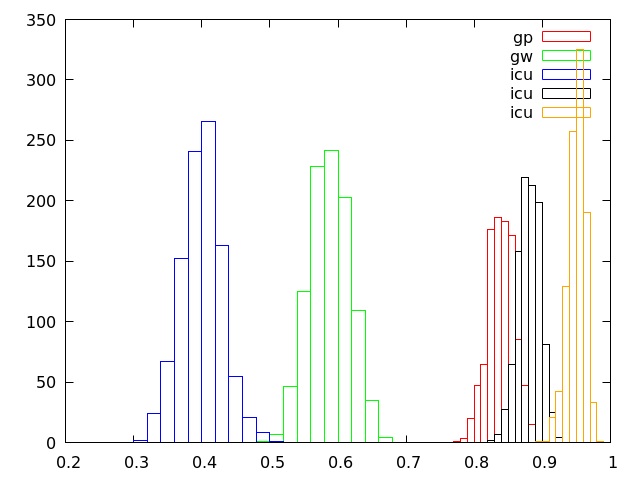

In [56]:
function get_gp_days()
    expo = rand(expo_dist) # exposure days
    symp = rand(symp_dist) # symptomatic days
    return (expo, symp)
end

function get_prophylaxis_cost(sc, pr) 
    # sc is the scenario, 
    # pr is the population data for whatever simulation number
    # col names in pr: pop0to2_H  inf0to2_P  pop3to5_H  pop3to5_P  pop6to11_H  pop6to11_P  pop12to23_H  pop12to23_P  pop24to35    
    totalcost = 0 
    if sc == "S2"
        totalcost = sum(5 .* collect(pr[[:inf0to2_P, :pop3to5_P, :pop6to11_P]]) .*  [1065, 1567, 2048])
    end
    if sc == "S3" 
        totalcost = sum(1 .* collect(pr[[:inf0to2_P, :pop3to5_P, :pop6to11_P]]) .*  [1065, 1567, 2048])
    end
    if sc == "S4"
        totalcost = 1560 * sum(pr[[:pop0to2_H, :inf0to2_P]])
    end
    if sc == "S5" 
        totalcost = sum(5 .* collect(pr[[:pop0to2_H, :inf0to2_P, :pop3to5_P, :pop6to11_P]]) .* [1065, 1065, 1567, 2048])
    end
    if sc == "S6" 
        totalcost = sum(1 .* collect(pr[[:pop0to2_H, :inf0to2_P, :pop3to5_P, :pop6to11_P]]) .* [1065, 1065, 1567, 2048])
    end
    if sc == "S7" 
        _resvax = 1560 * sum(pr[[:pop0to2_H, :inf0to2_P]])
        _lama = sum(1 .* collect(pr[[:pop3to5_P, :pop6to11_P]]) .* [1567, 2048])
        totalcost = _resvax + _lama
    end
    return totalcost
end

function get_beta_parm(mu::Float64, se::Float64)
    var = se^2
    alpha = ((1 - mu) / var - 1 / mu) * mu ^ 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta
end

gp_samp = 1 .- rand(Beta(get_beta_parm(0.16, 0.02)...), 1000)
gw_samp = 1 .- rand(Beta(get_beta_parm(0.41, 0.03)...), 1000)
icu_samp = 1 .- rand(Beta(get_beta_parm(0.60, 0.03)...), 1000)
year_samp = 1 .- rand(Beta(45.8, 335.9), 1000)
avert_samp = 1 .- rand(Beta(16.5, 313.6), 1000)

@gp hist(gp_samp).bins hist(gp_samp).counts "w boxes t 'gp' lc rgb 'red'"
@gp :- hist(gw_samp).bins hist(gw_samp).counts "w boxes t 'gw' lc rgb 'green'"
@gp :- hist(icu_samp).bins hist(icu_samp).counts "w boxes t 'icu' lc rgb 'blue'"
@gp :- hist(year_samp).bins hist(year_samp).counts "w boxes t 'icu' lc rgb 'black'"
@gp :- hist(avert_samp).bins hist(avert_samp).counts "w boxes t 'icu' lc rgb 'orange'"

In [61]:
function cost_eff(season, c1, c2) 
    
    # THE LABELS HERE DO NOT MATCH THE LABELS USED IN THE MAIN TEXT BUT THE SCENARIOS ARE CORRECT
    
    # read population file for prophylaxis
    pop = CSV.File(fp * "population.csv", normalizenames=true) |> DataFrame 
    select!(pop, Not([1,4,7,10]))
    #col names: pop0to2_H  inf0to2_P  pop3to5_H  pop3to5_P  pop6to11_H  pop6to11_P  pop12to23_H  pop12to23_P  pop24to35
    
    # read infection file as well 
    #_infection = CSV.File(fp * "infection_$(season).csv") |> DataFrame    
    #select!(_infection, [:inf0to2_total, :inf3to5_total, :inf6to11_total]) # take out 'total infection' columns per agegroup
    #inf = Matrix(_infection) # convert to matrix
    
    if c1 == "S1" && c2 == "S2"
        func = S1_S2S3
    elseif c1 == "S1" && c2 == "S3"
        func = S1_S2S3
    elseif c1 == "S1" && c2 == "S4"
        func = S1S4
    elseif c1 == "S2" && c2 == "S5"
        func = S2S5
    elseif c1 == "S3" && c2 == "S6"
        func = S2S5
    elseif c1 == "S1" && c2 == "S7" 
        func = S1S7
    end
    
    gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2 = func(season, c1, c2)  #  (gp_c1, gw_c1, icu_c1, _updated_gp_c2, gw_c2, icu_c2, final_averted_c2)
    allmats = Dict("c1" => (gp_c1, gw_c1, icu_c1), "c2" => (_updated_gp_c2, gw_c2, icu_c2))
    
    # simulation level analysis
    totalqalys = zeros(Float64, 500, 6) |> NamedArray 
    setnames!(totalqalys, ["totalinf_c1", "qalys_c1", "totalinf_c2", "totalinf_averted", "qalys_averted", "qalys_c2"], 2) 
    
    totalcosts = zeros(Float64, 500, 6) |> NamedArray 
    setnames!(totalcosts, ["s1cost_c1", "s1cost_c2", "intercost_c1", "intercost_c2", "totalcosts_c1", "totalcosts_c2"], 2) 
    
    # setup disutility distributions
    gp_dist = Beta(get_beta_parm(0.16, 0.02)...)
    gw_dist = Beta(get_beta_parm(0.41, 0.03)...)
    icu_dist = Beta(get_beta_parm(0.60, 0.03)...)
    year_dist = Beta(45.8, 335.9)
    avert_dist = Beta(19.2, 364.6)
    
    for sim = 1:500         
        # loop through baseline scenario vs comparion scenario
        gp_disrate = 1 - rand(gp_dist)
        gw_disrate = 1 - rand(gw_dist)
        icu_disrate = 1 - rand(icu_dist)
        year_disrate = 1 - rand(year_dist)
        avert_disrate = 1 - rand(avert_dist)
        sgp = get_gp_days() # sample the incubation + symptomatic period
        
        for cval in ("c1", "c2")
            # for each scenario, get the right dataframe
            df_gp, df_gw, df_icu = allmats[cval]
            
            # clinic days as sampled, but don't depend on age groups so just add the entire row to get the total number of gp/clinic in simulation i
            # calculate qalys and costs (qalys get added to main table later)
            gp_days = sgp[1] + sgp[2] # sum the exp + symptomatic days                     
            gp_qalys = sum(df_gp[sim, :]) * (gp_disrate * gp_days/365 + year_disrate*(365 - gp_days)/365)
            gp_costs = sum(df_gp[sim, :]) * 1569
            #sim == 1 && println("scenario: $cval gp sum: $(sum(df_gp[sim, :])) ")
            # for general ward calculation, we need to differentiate slightly between age groups and how long they spend at the hospital
            # so days are: for months 0 to 2: = 3 days, 3 to 5 = 3 days, 6 to 11 = 4 days             
            # the QALY calculation is as follows: 
            # incubation period + hospital period (3 or 4 days fixed) + (symptomatic - hospital)
            # each of these periods are multiplied by their respective weights... the incubation/symptomatic period is the "clinic" weight, while the hospital part is the hospital rate
            # note that incubation/symptomatic periods are sampled
            # make sure to account for units... sgp is a variable in days... but in qaly calculations, it's divided by 365
            # i turned _qalydays into anon function, with input that's going to be either 3 or 4 depending on the age group
            
            _qalydays = x -> (sgp[1]/365*gp_disrate + x/365*gw_disrate + (sgp[2] - 3)/365*gp_disrate)
            _remaindays = x -> (year_disrate * (365 - (sgp[1] + sgp[2] + x))/365)
            _gw_days_ag1 = sum(df_gw[sim, [1,2]]) * (_qalydays(3) + _remaindays(3))
            _gw_days_ag2 = sum(df_gw[sim, [3,4]]) * (_qalydays(3) + _remaindays(3))
            _gw_days_ag3 = sum(df_gw[sim, [5,6]]) * (_qalydays(4) + _remaindays(4))            
            gw_qalys = _gw_days_ag1 + _gw_days_ag2 + _gw_days_ag3
            gw_costs = sum(df_gw[sim, :]) * 16946
            #sim == 1 && println("scenario: $cval gw sum: $(sum(df_gw[sim, :])) ")
            
            # the process to calculate ICU qalys is similar
            # the qaly calculation is as follows: incubation + hosp + icu 
            # first, I keep the hosp fixed at 3 days for all age groups (only in this icu case).. the difference is neglible. 
            _qalydays = x -> (sgp[1]/365*gp_disrate + 3/365*gw_disrate + x/365*icu_disrate)
            _remaindays = x -> (year_disrate * (365 - (sgp[1] + 3 + x))/365)            
            _icu_days_ag1 = sum(df_icu[sim, [1, 2]]) * (_qalydays(9.5) + _remaindays(9.5))
            _icu_days_ag2 = sum(df_icu[sim, [3, 4]]) * (_qalydays(9.5) + _remaindays(9.5))
            _icu_days_ag3 = sum(df_icu[sim, [5, 6]]) * (_qalydays(6.5) + _remaindays(6.5))
            icu_qalys = _icu_days_ag1 + _icu_days_ag2 + _icu_days_ag3
            icu_costs = sum(df_icu[sim, :]) * rand(64000:70000) # icu_cost ##  #80590
            #sim == 1 && println("scenario: $cval icu sum: $(sum(df_icu[sim, :])) ")
            
            # we have to calculate the cost of drugs/vaccine of the population
            # these costs depend on the scenario being run.
            if cval == "c1" 
                prof_cost = get_prophylaxis_cost(c1, pop[sim, :])
            else 
                prof_cost = get_prophylaxis_cost(c2, pop[sim, :])
            end
            
            # get the total number of infected
            totalinf = sum(df_gp[sim, :]) + sum(df_gw[sim, :]) + sum(df_icu[sim, :])
            
            totalqalys[sim, "totalinf_$cval"] = totalinf
            totalqalys[sim, "qalys_$cval"] = gp_qalys + gw_qalys + icu_qalys            
            totalcosts[sim, "s1cost_$(cval)"] = gp_costs + gw_costs + icu_costs
            totalcosts[sim, "intercost_$(cval)"] = prof_cost
        end
    end
    totalqalys[:, "totalinf_averted"] .= dropdims(sum(final_averted_c2, dims=2), dims=2)
    totalqalys[:, "qalys_averted"] .= totalqalys[:, "totalinf_averted"] * 0.95  # averted people (i.e. from clinic, ward, icu) have a 0.88 quality of life due to RSV
    totalqalys[:, "qalys_c2"] .= totalqalys[:, "qalys_c2"] .+ totalqalys[:, "qalys_averted"]
    totalcosts[:, "totalcosts_c1"] .=  totalcosts[:, "s1cost_c1"] + totalcosts[:, "intercost_c1"]
    totalcosts[:, "totalcosts_c2"] .=  totalcosts[:, "s1cost_c2"] + totalcosts[:, "intercost_c2"]
    0
    totalqalys, totalcosts
    #dropdims(sum(final_averted_c2, dims=2), dims=2)
end

cost_eff (generic function with 1 method)

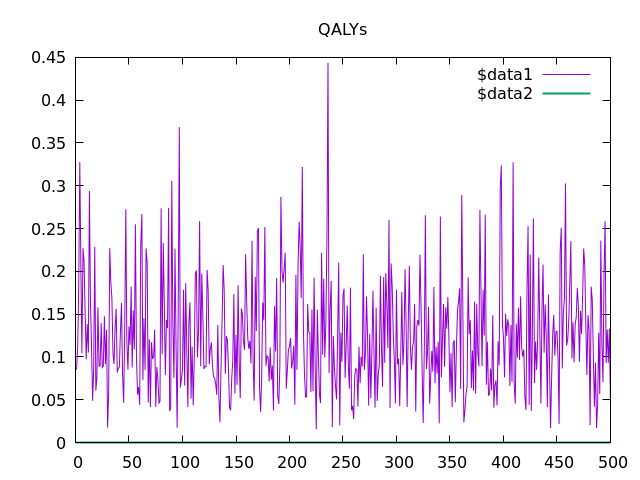

res[1:10, :] = 10×6 Named Matrix{Float64}
A ╲ B │      totalinf_c1          qalys_c1       totalinf_c2  totalinf_averted     qalys_averted          qalys_c2
──────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
1     │            140.0           122.909            139.24              0.76             0.722           122.994
2     │            135.0           121.267            133.76              1.24             1.178           121.378
3     │             89.0           75.7528             87.82              1.18             1.121           75.9306
4     │            135.0           118.678             131.9               3.1             2.945           119.005
5     │            136.0           118.584            134.14              1.86             1.767            118.79
6     │            129.0           109.955            128.24              0.76             0.722           110.059
7     │             84.0            73

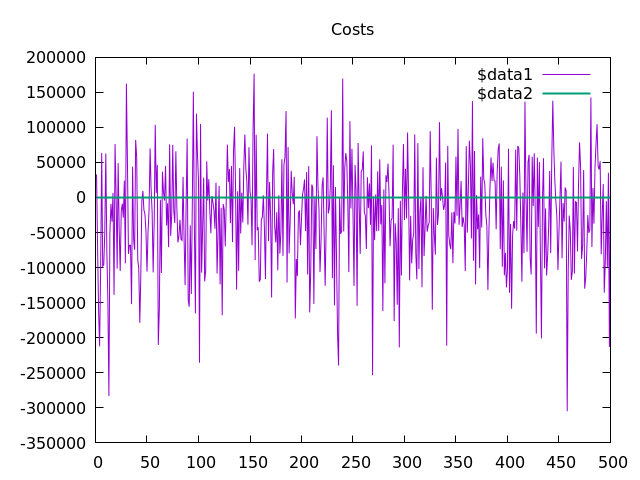

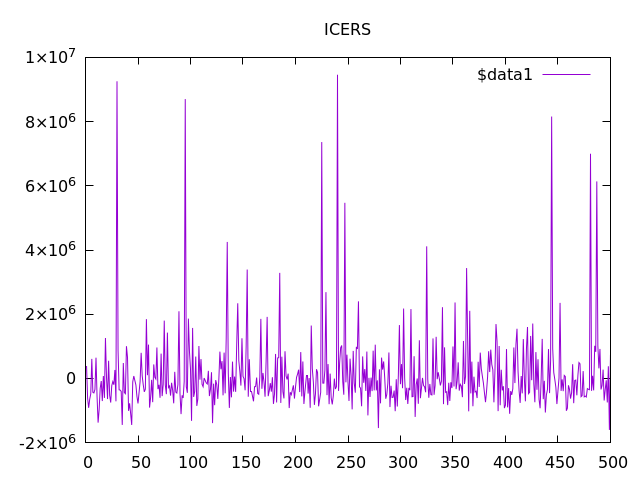

In [63]:
# Example run of a scenario

res, csts = cost_eff("mild", "S1", "S7")
@show res[1:10, :]
diffqalys = res[:, "qalys_c2"] - res[:, "qalys_c1"]
diffcosts = csts[:, "totalcosts_c2"] - csts[:, "totalcosts_c1"]

println("mean: $(mean(diffqalys))")
println("mean cost: $(mean(diffcosts))")
println("mean icer: $(mean(diffcosts) / mean(diffqalys))")
println("")


@gp "reset" 
#@gp :- "set yrange [-0.35:0.2]"
@gp :- "set title 'QALYs'"
@gp :- 1:500 diffqalys "with lines"
@gp :- 1:500 zeros(500) "with lines lw 2"
display(@gp)

@gp "reset" 
#@gp :- "set yrange [-0.35:0.2]"
@gp :- "set title 'Costs'"
@gp :- 1:500 diffcosts "with lines"
@gp :- 1:500 zeros(500) "with lines lw 2"
display(@gp)

@gp "reset" 
#@gp :- "set yrange [0:1000]"
@gp :- "set title 'ICERS'"
@gp :- 1:500 ((diffcosts ./ diffqalys)) "with lines"
#@gp :- 1:500 zeros(500) "with lines lw 2"
display(@gp)


In [62]:
# S1 S2  no intervention, pal (pre)
# S1 S3  no intervention, lama (pre)

# S2 S5  pal (pre), pal (pre + healthy)
# S3 S6  lama (pre), lama (pre + healthy)

# Run the function and save the results in 3 separate files

scs = [("S1", "S2"), ("S1", "S3"), ("S2", "S5"), ("S3", "S6"), ("S1", "S4"), ("S1", "S7")]

for (i, ses) in enumerate(["mild", "moderate", "severe"])
   
    filetosave = zeros(500, 12)    
    for (j, (c1, c2)) in enumerate(scs)
        println("$c1 vs $c2 -- season: $ses, idx: $i, $(j*2-1), $(j*2)")
        res, csts = cost_eff(ses, c1, c2)
        diffqalys = res[:, "qalys_c2"] - res[:, "qalys_c1"]
        diffcosts = csts[:, "totalcosts_c2"] - csts[:, "totalcosts_c1"]
       
        println("mean: $(mean(diffqalys))")
        println("mean cost: $(mean(diffcosts))")
        println("mean icer: $(mean(diffcosts) / mean(diffqalys))")
        println("")

        filetosave[:, j*2-1] .= diffqalys
        filetosave[:, j*2] .= diffcosts
    end
    fdf = DataFrame(filetosave, :auto)
    CSV.write("rsv_$(ses).csv", fdf, writeheader=false)
end

S1 vs S2 -- season: mild, idx: 1, 1, 2
mean: 0.0839718570877799
mean cost: 84822.61408
mean icer: 1.0101314538194714e6

S1 vs S3 -- season: mild, idx: 1, 3, 4
mean: 0.08131197846042792
mean cost: -71862.86391999999
mean icer: -883791.8506062852

S2 vs S5 -- season: mild, idx: 1, 5, 6
mean: 0.8906253633184035
mean cost: 392699.72312
mean icer: 440925.82503694954

S3 vs S6 -- season: mild, idx: 1, 7, 8
mean: 0.8907137927413831
mean cost: 35106.60112
mean icer: 39414.00863677108

S1 vs S4 -- season: mild, idx: 1, 9, 10
mean: 0.06386342763665592
mean cost: 14568.006719999976
mean icer: 228111.88279594196

S1 vs S7 -- season: mild, idx: 1, 11, 12
mean: 0.1258756906889022
mean cost: -25761.872880000003
mean icer: -204661.22361679556

S1 vs S2 -- season: moderate, idx: 2, 1, 2
mean: 0.1660645840591874
mean cost: 2281.4015200000117
mean icer: 13738.037721437902

S1 vs S3 -- season: moderate, idx: 2, 3, 4
mean: 0.16611132967197803
mean cost: -154867.32848
mean icer: -932310.4497797851

S2 vs S5